# Tuning 

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [2]:
%load_ext watermark

In [3]:
import pandas as pd
import numpy as np
from random_forest_mc.model import RandomForestMC
from random_forest_mc.utils import LoadDicts, dump_file_json, load_file_json
from tqdm.notebook import tqdm
from datetime import datetime
from collections import Counter, defaultdict
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [4]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [5]:
import functools
import operator
def flat(a):
    return functools.reduce(operator.iconcat, a, [])

In [6]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.27.0

Compiler    : GCC 10.2.1 20210110
OS          : Linux
Release     : 6.8.0-44-generic
Machine     : x86_64
Processor   : 
CPU cores   : 20
Architecture: 64bit

Git hash: 2567a478ebf147744980cf5e4a612cf661cced24

Git repo: https://github.com/ysraell/random-forest-mc-utils.git

Git branch: main

numpy : 1.26.4
pandas: 2.2.2

CPU	: 12th Gen Intel(R) Core(TM) i7-12700
Mem:            15G
Swap:          3.7G


In [7]:
dataset_path = '/work/tmp/credit-card-fraud-prediction'

In [8]:
!ls $dataset_path

model_trans_tuning_16trees_20240916_0001.json
model_trans_tuning_16trees_20240916_0022.json
model_trans_tuning_288trees_20240916_0237.json
model_trans_tuning_32trees_20240916_0032.json
model_trans_tuning_8trees_20240915_2355.json
model_trans_tuning_8trees_20240916_0016.json
model_tuning2_64trees_20240914_2326.json
model_tuning3_256trees_20240915_1729.json
model_tuning_320trees_20240914_2145.json
sample_submission.csv
submission_exp1.csv
test.csv
test_trans.csv
train.csv
train_trans.csv
trees_metrcis_sim2_20240915_1804.json
trees_metrcis_sim_20240915_1425.json
trees_trans_metrcis_sim_20240916_0327.json


In [9]:
df = pd.read_csv(f'{dataset_path}/train_trans.csv')
#df = df.drop(columns='Time')
target_col = 'IsFraud'
df[target_col] = df[target_col].astype(str)
feat_cols = df.columns.to_list()
feat_cols.remove('id')
feat_cols.remove(target_col)
IsFraud_count, Not_IsFraud_count = df[target_col].value_counts()['1'], df[target_col].value_counts()['0']
IsFraud_count, Not_IsFraud_count

(269, 149731)

In [10]:
split_schema = {
    'test': {
        '1': 100,
        '0': 10000,
    },
    'train': {
        '1': 100,
        '0': 50000,
    },
    'val': {
        '1': 69,
        '0': 6900,
    }
}

In [11]:
df_tmp = df.copy()

dfs = {}
for ds_set in split_schema.keys():
    df_set = pd.concat([
        df_tmp.query(f'{target_col} == "{target_val}"').sample(n=split_schema[ds_set][target_val], random_state=42)
        for target_val in ['1', '0']
    ])
    df_tmp = df_tmp.drop(df_set.index).reset_index(drop=True)
    dfs[ds_set] = df_set.reset_index(drop=True)

df_tofit = pd.concat([dfs['train'], dfs['val']])

In [12]:
df_tmp.shape[0], df_tofit.shape[0], dfs['test'].shape[0], df_tmp.shape[0] + df_tofit.shape[0] + dfs['test'].shape[0]

(82831, 57069, 10100, 150000)

In [13]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = None
n_trees = 8
max_discard_trees = 256
min_feature = 2
max_feature = None

cpu_cores = 8
max_workers = 7

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

RandomForestMC(len(Forest)=0,n_trees=8,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [14]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

# Create the model

In [15]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

8 Trees


,Pred False,Pred True
False,6793,3207
True,42,58


Acc: 67.8317% 
 F1: 3.4473% 
 FN: 42.0000%
Feat count stats: (8.125, 1.964529205687714, 3, 9)


[(9, 6), (3, 1), (8, 1)]

In [17]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

16 Trees


,Pred False,Pred True
False,7517,2483
True,42,58


Acc: 75.0000% 
 F1: 4.3923% 
 FN: 42.0000%
Feat count stats: (7.875, 1.964529205687714, 3, 9)


[(9, 11), (3, 1), (8, 1), (5, 1), (7, 1), (4, 1)]

In [19]:
cls.n_trees = 16

In [20]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [21]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

32 Trees


,Pred False,Pred True
False,8190,1810
True,52,48


Acc: 81.5644% 
 F1: 4.9030% 
 FN: 52.0000%
Feat count stats: (7.9375, 2.2211694554896075, 2, 10)


[(9, 22), (3, 2), (4, 2), (10, 2), (8, 1), (5, 1), (7, 1), (2, 1)]

In [22]:
cls.n_trees = 256

In [23]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/256 [00:00<?, ?it/s]

In [24]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

288 Trees


,Pred False,Pred True
False,9099,901
True,53,47


Acc: 90.5545% 
 F1: 8.9695% 
 FN: 53.0000%
Feat count stats: (8.23611111111111, 1.846491083376157, 2, 10)


[(9, 218), (4, 12), (8, 11), (10, 11), (3, 9), (5, 8), (7, 7), (2, 6), (6, 6)]

# Search for the best set of trees

In [57]:
cls = RandomForestMC(target_col=target_col)
cls.process_dataset(df_tofit)

In [58]:
!ls $dataset_path/model_trans_tuning*

/work/tmp/credit-card-fraud-prediction/model_trans_tuning3_256trees_20240916_1416.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_16trees_20240916_0001.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_16trees_20240916_0022.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_288trees_20240916_0237.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_32trees_20240916_0032.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_8trees_20240915_2355.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_8trees_20240916_0016.json


In [59]:
model_json = f'{dataset_path}/model_trans_tuning3_256trees_20240916_1416.json'
model_dict = load_file_json(model_json)
cls.dict2model(model_dict)
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

,Depths
count,53993.000000
mean,8.818143
std,0.828708
min,5.000000
25%,8.000000
50%,9.000000
75%,9.000000
max,11.000000


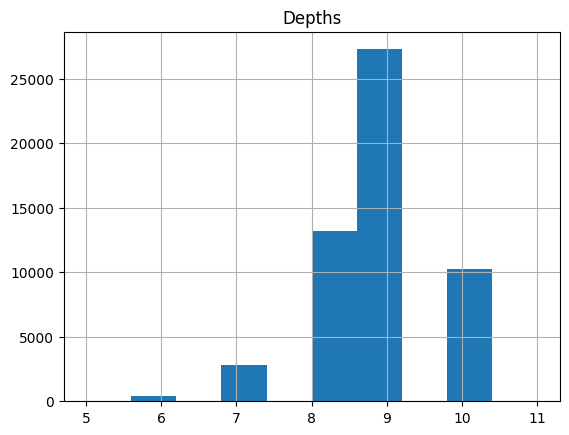

In [49]:
dps = cls.trees2depths
df_dethps = pd.DataFrame(flat(dps), columns=['Depths'])
df_dethps.hist()
df_dethps.describe()

In [26]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="score")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

  0%|          | 0/287 [00:00<?, ?it/s]

,0
count,287.000000
mean,48.174216
std,2.533199
min,36.000000
25%,47.000000
50%,48.000000
75%,49.000000
max,68.000000


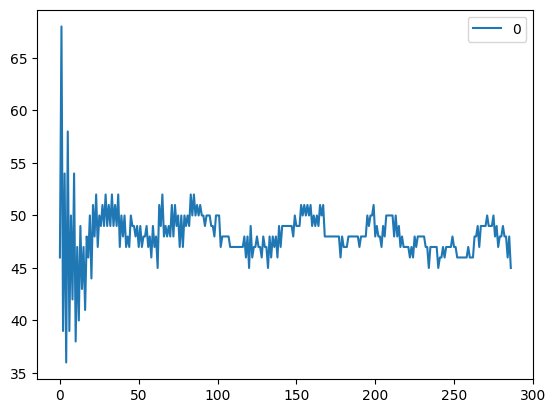

In [27]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

,0
count,287.000000
mean,48.174216
std,2.533199
min,36.000000
25%,47.000000
50%,48.000000
75%,49.000000
max,68.000000


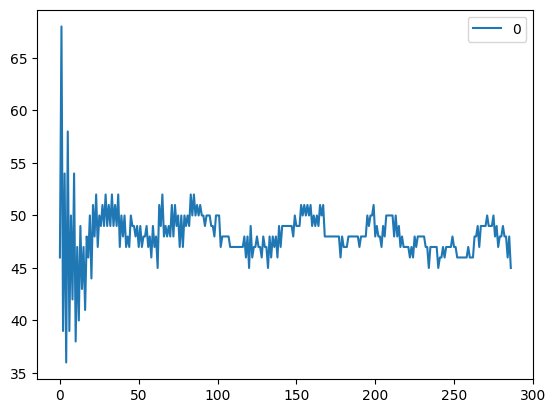

In [28]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [29]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="random")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

  0%|          | 0/287 [00:00<?, ?it/s]

,0
count,287.000000
mean,47.365854
std,3.842432
min,40.000000
25%,45.000000
50%,47.000000
75%,49.000000
max,71.000000


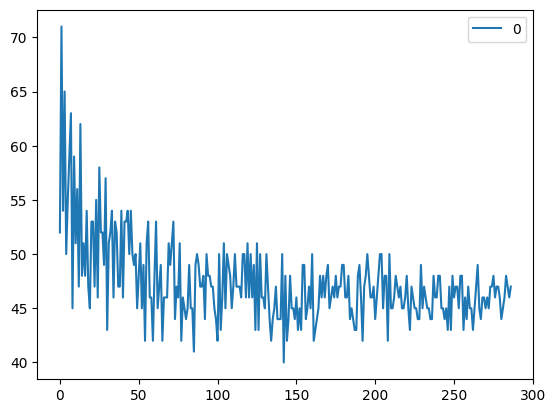

In [30]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

,0
count,287.000000
mean,47.365854
std,3.842432
min,40.000000
25%,45.000000
50%,47.000000
75%,49.000000
max,71.000000


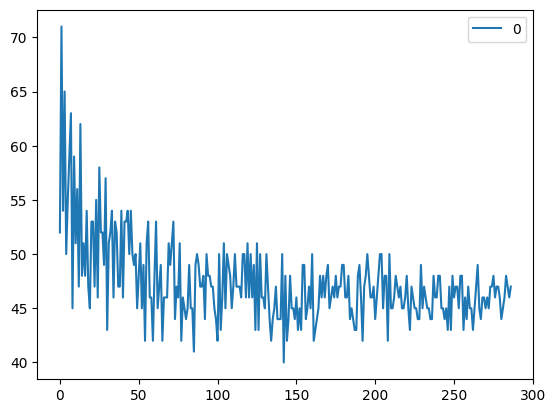

In [31]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [32]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 100

data = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/287 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: >

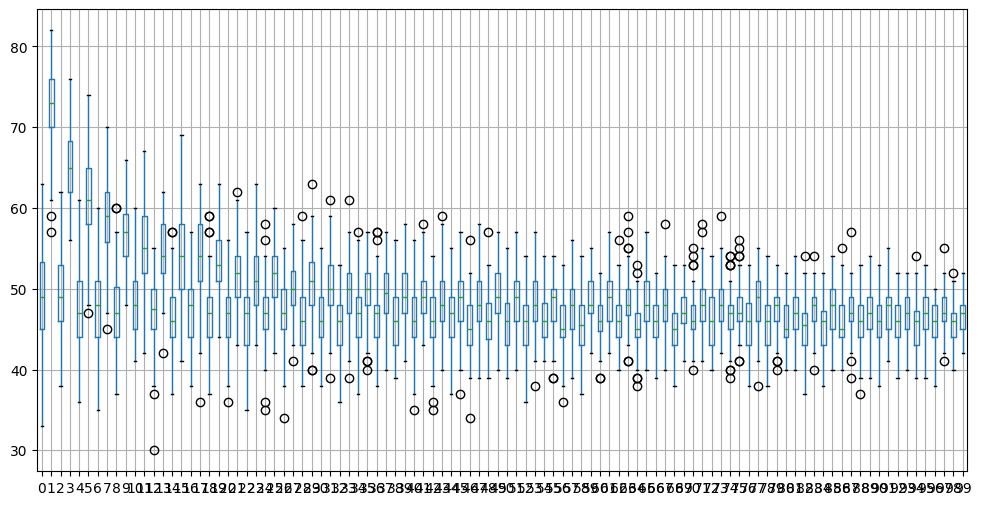

In [33]:
df = pd.DataFrame(data).T

plt.figure()
df.boxplot()

In [34]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
1,100.0,72.35,4.560203,57.0,70.00,73.0,76.00,82.0
3,100.0,65.00,4.666667,56.0,62.00,65.0,68.25,76.0
5,100.0,61.12,5.182098,47.0,58.00,61.0,65.00,74.0
7,100.0,58.69,4.585209,45.0,55.75,59.0,62.00,70.0
9,100.0,56.95,4.000947,48.0,54.00,57.0,59.25,66.0
11,100.0,55.51,4.953307,42.0,52.00,55.0,59.00,67.0
13,100.0,54.46,3.937440,42.0,52.00,54.0,58.00,62.0
15,100.0,54.14,5.719045,41.0,50.00,54.0,58.00,69.0
17,100.0,54.06,5.122381,36.0,51.00,54.0,58.00,63.0
19,100.0,53.17,4.226073,44.0,51.00,53.0,56.00,63.0


In [35]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 1000

data = []
final_N = 10
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: >

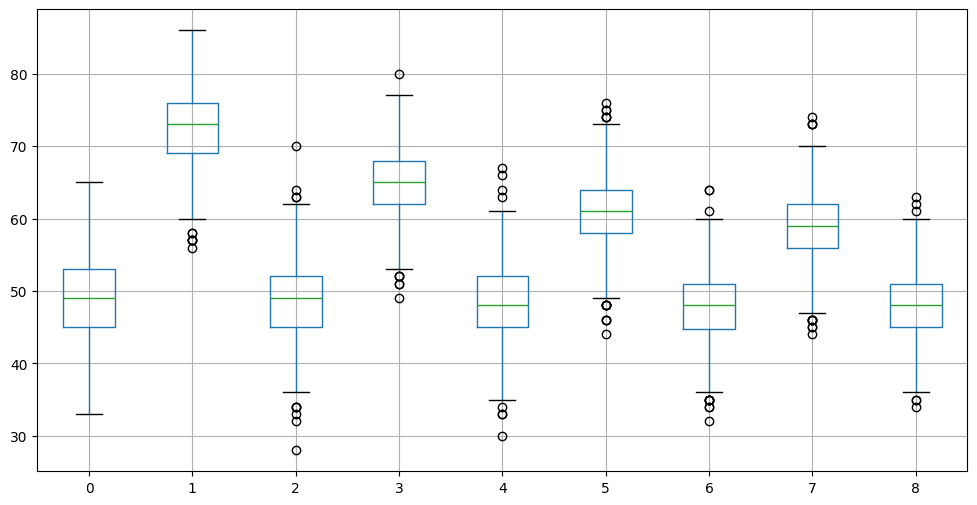

In [36]:
df = pd.DataFrame(data).T

plt.figure()
df.boxplot()

In [37]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
1,1000.0,72.571,5.186893,56.0,69.00,73.0,76.0,86.0
3,1000.0,64.853,4.995232,49.0,62.00,65.0,68.0,80.0
5,1000.0,61.223,4.923567,44.0,58.00,61.0,64.0,76.0
7,1000.0,58.797,4.929512,44.0,56.00,59.0,62.0,74.0
0,1000.0,49.123,6.030443,33.0,45.00,49.0,53.0,65.0
2,1000.0,48.733,5.389319,28.0,45.00,49.0,52.0,70.0
4,1000.0,48.385,5.215551,30.0,45.00,48.0,52.0,67.0
6,1000.0,47.905,5.089192,32.0,44.75,48.0,51.0,64.0
8,1000.0,47.893,4.761956,34.0,45.00,48.0,51.0,63.0


# Tunning 3 with search 2-4-6-trees

In [38]:
cls.drop_duplicated_trees()

0

In [39]:
cls

RandomForestMC(len(Forest)=288,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [41]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [2, 4, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_trans_metrcis_sim_{datetime_tag}.json", data)

In [ ]:
len(data)

### Analysing the results

In [ ]:
!ls $dataset_path/trees_metrcis_sim_*.json

In [ ]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_*.json')

In [43]:
md5_trees = list(data.keys())

In [44]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
0,6.000000,9.0,10.0,0.707273,0.278008,0.530000,c6e510d23997e733f02b579b20673584
1,4.646925,9.0,10.0,0.573212,0.220217,0.344556,c6e510d23997e733f02b579b20673584
2,6.000000,9.0,10.0,0.684545,0.276000,0.500000,8c976ceb222e3d69ef68f061cb9b814a
3,4.661692,9.0,10.0,0.576531,0.224008,0.333806,8c976ceb222e3d69ef68f061cb9b814a
4,6.000000,9.0,10.0,0.654545,0.267857,0.490000,6ac8be2b0dc3bdf7c4db893804a1bf42
...,...,...,...,...,...,...,...
571,4.748235,9.0,10.0,0.546036,0.202466,0.373647,831ef917dbe40d856db3e5fbd4e50495
572,6.000000,9.0,10.0,0.690909,0.276008,0.530000,671634d660b107215702ca7ed21a751a
573,4.633094,9.0,10.0,0.584886,0.219162,0.364628,671634d660b107215702ca7ed21a751a
574,6.000000,9.0,10.0,0.658182,0.262231,0.520000,9145604af4cab63bf8e04559c5e3756d


In [45]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
288,6.0,8.0,10.0,0.722727,0.285714,0.55,ef556a3c230bab32bb4ee14018ec7722
450,6.0,9.0,10.0,0.722727,0.285714,0.54,ef2c5aa3068228720ecab33d1a15b59b
36,6.0,9.0,10.0,0.722727,0.285714,0.50,295a7ef56c2489b7c57f77dd3993a3c4
166,6.0,9.0,10.0,0.722727,0.285714,0.56,79062402470c51379b5336bef975dbd0
408,6.0,9.0,10.0,0.722727,0.285714,0.53,42f3d341ceaf051aa4a173fd43716ab5
330,6.0,9.0,10.0,0.722727,0.285714,0.48,b4bf1b5431a38d37db8cfef0122d29b7
92,6.0,9.0,10.0,0.685455,0.285124,0.51,eab711ef351b61eb465724efd81c65bc
62,6.0,9.0,10.0,0.685455,0.285124,0.55,806b46cecc32adad041de2a1cdaeec1e
252,6.0,9.0,10.0,0.696364,0.285124,0.53,50d7b76d98829a730118283857a07b1f
300,6.0,9.0,10.0,0.694545,0.285124,0.54,ca81ef386163bad51081c509359dd7bc


In [46]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
181,4.519608,9.0,10.0,0.544563,0.224387,0.282255,1badb983fa776a93c4808da3a67e212d
305,4.595843,9.0,10.0,0.540296,0.218287,0.301132,3c5569ce72a493a3e3826e961f5c64b8
109,4.590164,5.0,10.0,0.558959,0.223912,0.306768,c71a65d909a8c75a995cf295df8d5f1a
211,4.568182,4.0,10.0,0.542746,0.217004,0.310068,8cf6c2613a3ad2e40440ba178ec074cc
5,4.617117,9.0,10.0,0.537160,0.214893,0.310203,6ac8be2b0dc3bdf7c4db893804a1bf42
529,4.781395,9.0,10.0,0.572983,0.227845,0.312140,7f82a5def8b82f0bc7c60cf92c392acd
183,4.732719,9.0,10.0,0.572945,0.227771,0.312650,2478ccd4bc2de4896767d91101d03ec4
297,4.630385,9.0,10.0,0.532956,0.212855,0.313469,12ede1c0e5a66c7f38e06c682399e09b
35,4.610169,9.0,10.0,0.588162,0.233931,0.313777,59b45573bbd659d41c231178f4856d96
51,4.675737,9.0,10.0,0.586840,0.232850,0.315351,8b40e4d2083bd35b9ecb3193d33bb154


<Axes: >

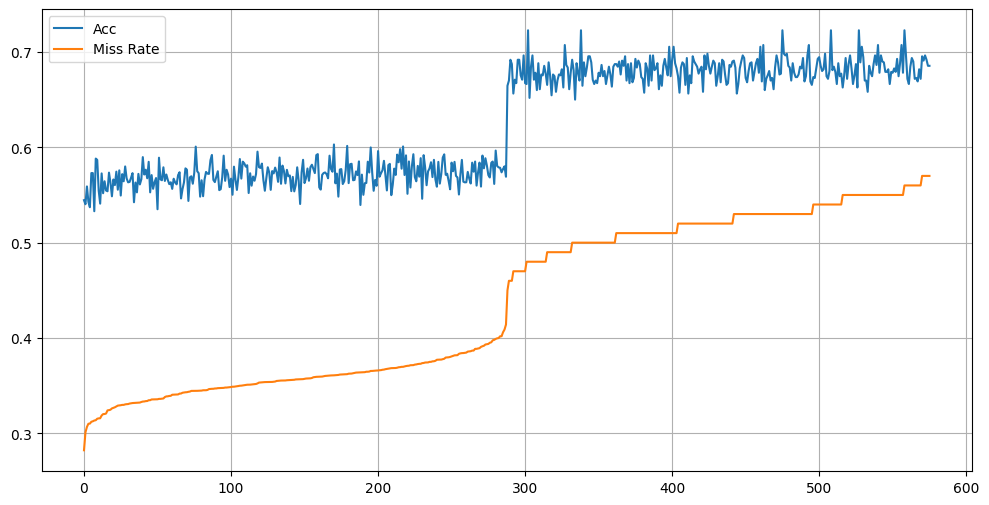

In [47]:
df_trees.sort_values(by='Miss Rate')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

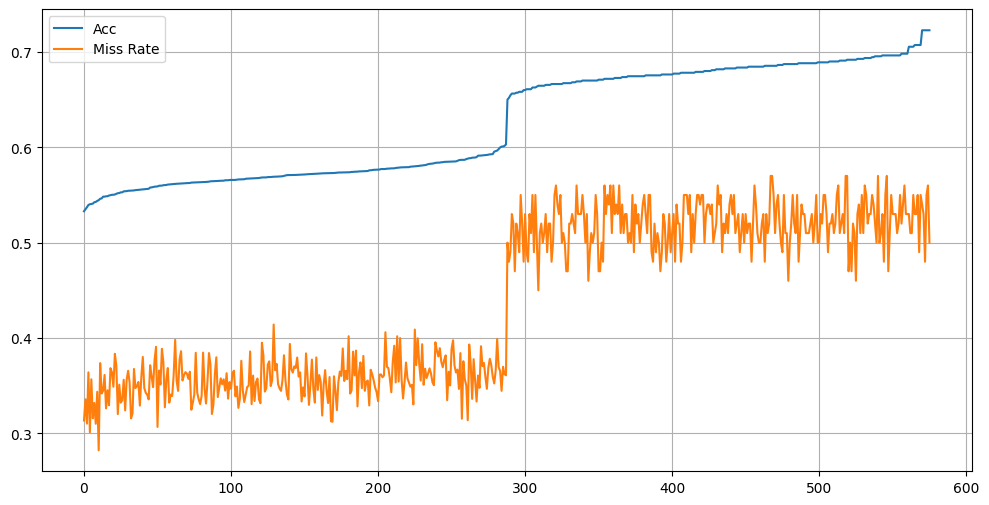

In [48]:
df_trees.sort_values(by='Acc')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

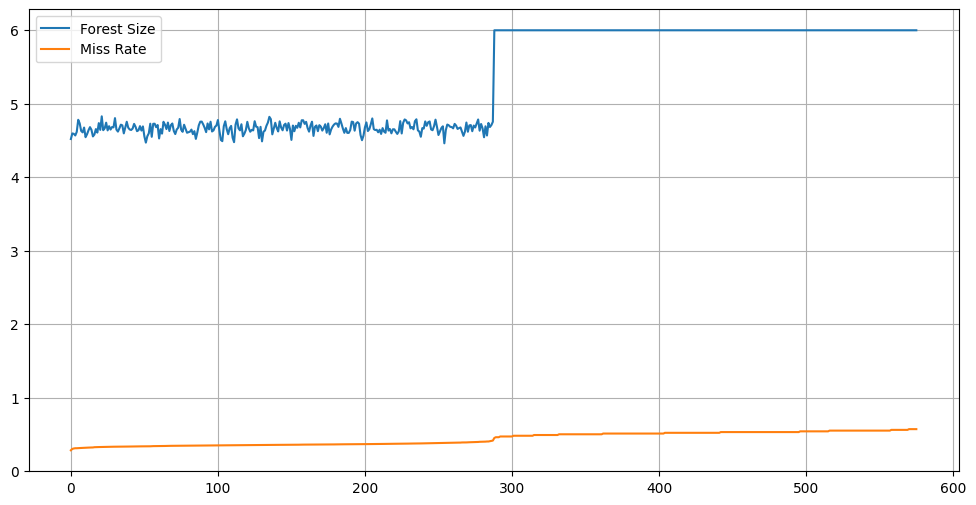

In [49]:
df_trees.sort_values(by='Miss Rate')[['Forest Size', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

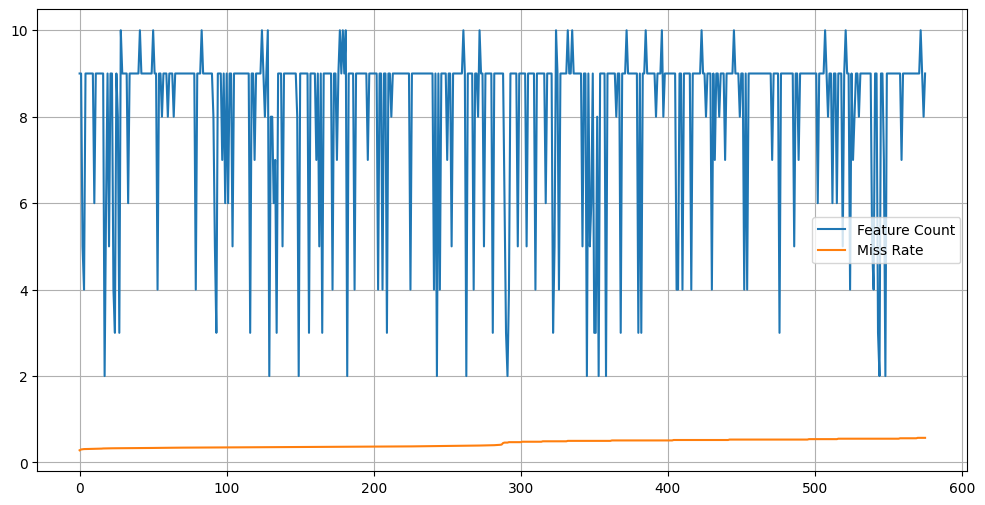

In [50]:
df_trees.sort_values(by='Miss Rate')[['Feature Count', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

In [51]:
!touch /work/yes.do

# Tuning 3

In [15]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = None
n_trees = 256
max_discard_trees = 256
min_feature = 6
max_feature = 10

cpu_cores = 8
max_workers = 2*cpu_cores

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

RandomForestMC(len(Forest)=0,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [16]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

In [17]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning3_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/256 [00:00<?, ?it/s]

In [18]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

256 Trees


,Pred False,Pred True
False,9100,900
True,55,45


Acc: 90.5446% 
 F1: 8.6124% 
 FN: 55.0000%
Feat count stats: (7.83203125, 1.2243897455563066, 6, 10)


[(9, 108), (6, 60), (8, 51), (7, 35), (10, 2)]

In [19]:
cls.drop_duplicated_trees()

0

In [20]:
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [21]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [2, 4, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_trans_metrcis_sim2_{datetime_tag}.json", data)

In [23]:
len(data)

256

### Analysing the results

In [ ]:
!ls $dataset_path/trees_metrcis_sim2_*.json

In [ ]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_20240915_1804.json')

In [24]:
md5_trees = list(data.keys())

In [25]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
0,6.000000,9.0,10.0,0.688182,0.255965,0.590000,b94da7fc9bd4bc8955b3781b1edcbb30
1,4.686992,9.0,10.0,0.567788,0.203454,0.400346,b94da7fc9bd4bc8955b3781b1edcbb30
2,6.000000,9.0,10.0,0.703636,0.274194,0.500000,0b13f1f8e9df834495b1e91f256f88bb
3,4.758030,9.0,10.0,0.594205,0.224640,0.359465,0b13f1f8e9df834495b1e91f256f88bb
4,6.000000,7.0,10.0,0.686364,0.273469,0.540000,31b47a43789d96425cabe2fab053953b
...,...,...,...,...,...,...,...
507,4.644880,9.0,10.0,0.574203,0.214828,0.366928,7bcd53b7a48f2fe4eb7934b94d42063f
508,6.000000,6.0,10.0,0.683636,0.275449,0.530000,d19a7ee958cca3699e8cd0ff2e6cd099
509,4.562900,6.0,10.0,0.575460,0.222298,0.339062,d19a7ee958cca3699e8cd0ff2e6cd099
510,6.000000,8.0,10.0,0.676364,0.257812,0.580000,654b251a5109acff8aa5c1491ced31bd


In [26]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
52,6.0,6.0,10.0,0.709091,0.294949,0.54,4a9bbc93dbfdeb1a339055d495ed2635
490,6.0,6.0,11.0,0.693636,0.294949,0.56,8856f427ccebe9da8461bb3e5736ce3b
360,6.0,8.0,10.0,0.710909,0.294949,0.52,622de5582f1b48fa42f7039e39674393
138,6.0,9.0,10.0,0.710909,0.294949,0.51,47621e8e17e544dc40b6d883ca9030c3
400,6.0,8.0,10.0,0.709091,0.294949,0.51,3ecdbcc3deed665943f3b0f5d6351235
254,6.0,6.0,10.0,0.682727,0.294949,0.52,f9ff37bd55b4a881665afe766ca49756
12,6.0,6.0,10.0,0.704545,0.291939,0.53,db131474e1866929ab2d11293d61a508
58,6.0,9.0,10.0,0.704545,0.291939,0.51,f7e3a4e58e9c1f2e2d6d69a28a73d645
442,6.0,9.0,10.0,0.713636,0.291939,0.53,6c862987e269738c0788db6f77a1837c
278,6.0,9.0,10.0,0.707273,0.291939,0.53,126f4ad75f3e8aee40dcb39cbf050297


In [27]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
475,4.646421,8.0,10.0,0.560878,0.222085,0.318416,bf35e8a78360e673fba787c9fefd0fcf
423,4.640860,9.0,10.0,0.553756,0.219293,0.318473,a795db13b3f43f1b3c2329ff5f9f2d0b
167,4.621145,9.0,10.0,0.582185,0.230125,0.318965,7506422619b8cb6b412a1d8080ea71f8
437,4.719647,9.0,10.0,0.570413,0.224735,0.321413,53bd79855a8fe591a23451d0d05c63b4
339,4.697211,8.0,10.0,0.562718,0.221412,0.323506,7c625fa615517b064f29f38cf2c7dcb7
243,4.627451,7.0,10.0,0.586063,0.230319,0.326144,7570d14f98e0b0339a970389d35cc158
487,4.664987,6.0,10.0,0.558111,0.217740,0.330453,966ceff7358ace7a4e996610a06be6e9
9,4.631579,6.0,10.0,0.566411,0.220401,0.332232,f4e06b11932e5d3911eb4b937c53b241
71,4.656716,6.0,10.0,0.549773,0.214138,0.332687,2b37e24e8201361162395455aab1a306
439,4.755467,9.0,10.0,0.581609,0.226771,0.333419,87b906da73e48de65ca863860f762269


In [40]:
df_trees['My Score'] = 0.5*df_trees['Acc']-df_trees['Miss Rate']+df_trees['F1']

In [41]:
df_trees.sort_values(by='My Score', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree,My Score
167,4.621145,9.0,10.0,0.582185,0.230125,0.318965,7506422619b8cb6b412a1d8080ea71f8,0.202253
243,4.627451,7.0,10.0,0.586063,0.230319,0.326144,7570d14f98e0b0339a970389d35cc158,0.197206
437,4.719647,9.0,10.0,0.570413,0.224735,0.321413,53bd79855a8fe591a23451d0d05c63b4,0.188529
443,4.645418,9.0,10.0,0.607539,0.233180,0.348586,6c862987e269738c0788db6f77a1837c,0.188364
439,4.755467,9.0,10.0,0.581609,0.226771,0.333419,87b906da73e48de65ca863860f762269,0.184156
475,4.646421,8.0,10.0,0.560878,0.222085,0.318416,bf35e8a78360e673fba787c9fefd0fcf,0.184108
207,4.656250,6.0,10.0,0.583334,0.226161,0.335357,d3d11863520b6c727bb4300fe2bf4a0a,0.182471
259,4.837310,7.0,10.0,0.608347,0.231898,0.354707,d007f843d012c116ac6ed498ce038ef8,0.181365
401,4.604762,8.0,10.0,0.591045,0.228155,0.342333,3ecdbcc3deed665943f3b0f5d6351235,0.181344
461,4.539095,7.0,10.0,0.578648,0.225115,0.333663,89b06d20acba166395ab246462225793,0.180776


In [60]:
golden_trees = df_trees.sort_values(by='My Score', ascending=False).head(6).Tree.to_list()

In [61]:
cls.data = [Tree for Tree in cls.data if Tree.md5hexdigest in golden_trees]

In [62]:
cls

RandomForestMC(len(Forest)=6,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

# Generate the submission file

In [64]:
df_test = pd.read_csv(f'{dataset_path}/test_trans.csv')
df_test['Transaction_Amount'] = (df_test['Transaction_Amount'] * 100).astype(np.uint32)
df_test

,id,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount
0,150000,0.318355,0.321163,0.462163,0.756566,0.957549,0.668337,0.304175,0.191049,0.590411,...,0.806909,0.180823,0.700434,0.289070,0.800238,0.066284,0.751069,0.019574,0.020359,57
1,150001,0.157953,0.116052,0.442224,0.666073,0.854879,0.038326,0.790019,0.633170,0.608514,...,0.907089,0.774638,0.887381,0.275813,0.141341,0.152846,0.883049,0.963289,0.903018,51
2,150002,0.575795,0.365659,0.487609,0.125266,0.829039,0.255753,0.130055,0.024725,0.674943,...,0.915107,0.977730,0.986178,0.070841,0.231233,0.653077,0.571366,0.596056,0.721636,92
3,150003,0.733706,0.387797,0.233842,0.465443,0.857811,0.882159,0.029470,0.124882,0.819187,...,0.276938,0.376094,0.523755,0.588606,0.187639,0.812250,0.180992,0.763024,0.547735,32
4,150004,0.526584,0.364314,0.677058,0.142279,0.704843,0.753111,0.919480,0.045687,0.613396,...,0.318202,0.551307,0.578053,0.152166,0.463283,0.649355,0.333335,0.530985,0.717708,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69124,219124,0.946700,0.482789,0.635031,0.117141,0.002670,0.053935,0.408696,0.979986,0.969050,...,0.205887,0.262923,0.256931,0.476562,0.914507,0.588197,0.448856,0.240624,0.180632,92
69125,219125,0.491267,0.128343,0.229411,0.754758,0.006749,0.014178,0.338803,0.976500,0.131362,...,0.338346,0.974590,0.997693,0.434614,0.366381,0.006764,0.835440,0.967308,0.989621,51
69126,219126,0.982213,0.679197,0.271293,0.445455,0.036369,0.664091,0.638989,0.641462,0.245448,...,0.060191,0.119682,0.057690,0.954319,0.422145,0.119597,0.720867,0.141393,0.181480,14
69127,219127,0.986848,0.645635,0.852133,0.025489,0.049657,0.004620,0.518634,0.795943,0.996771,...,0.212513,0.750730,0.857209,0.948622,0.888000,0.064845,0.495666,0.679714,0.227132,79


In [65]:
df_id = df_test['id'].to_frame()
df_test = df_test.drop(columns=['id'])

In [66]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)

In [ ]:
!head $dataset_path/sample_submission.csv

In [67]:
df_id['IsFraud'] = y_pred_soft
df_id

,id,IsFraud
0,150000,0
1,150001,1
2,150002,1
3,150003,0
4,150004,1
...,...,...
69124,219124,1
69125,219125,0
69126,219126,0
69127,219127,1


In [68]:
df_id.to_csv(f'{dataset_path}/submission_exp2_trans.csv', index=False)

In [69]:
!head $dataset_path/submission_exp2_trans.csv

id,IsFraud
150000,0
150001,1
150002,1
150003,0
150004,1
150005,1
150006,1
150007,0
150008,1


# Kagle results

## Exp1:

Private Score: `0.53218`  (1st: `0.80611`)  
Public Score: `0.59206`  (1st: `0.83947`)  